# Práctica 2: Análisis exploratorio de dataset
## Vladimir García Loginova

## Procesamiento de "Rain in Australia" de kaggle

El dataset contiene cerca de 10 años de observaciones meteorológicas diarias de un gran número de estaciones meteorológicas en Australia.

Link del dataset: https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package

En la práctica pasada, se utilizó el mismo dataset para hacer un análisis exploratorio, con cierto pre-procesamiento de los datos, eligiendo diversas variables y ciudades de interés. En esta práctica se realiza limpieza de datos, reducción de dimensionalidad y  selección de características.

#### Importación de paqueterías

In [1]:
# importe de pauqterías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from umap import UMAP
import time

#### Lectura de dataset

In [2]:
file="weatherAUS.csv"
df=pd.read_csv(file,encoding = "ISO-8859-1")
print(df)

              Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0       2008-12-01   Albury     13.4     22.9       0.6          NaN   
1       2008-12-02   Albury      7.4     25.1       0.0          NaN   
2       2008-12-03   Albury     12.9     25.7       0.0          NaN   
3       2008-12-04   Albury      9.2     28.0       0.0          NaN   
4       2008-12-05   Albury     17.5     32.3       1.0          NaN   
...            ...      ...      ...      ...       ...          ...   
145455  2017-06-21    Uluru      2.8     23.4       0.0          NaN   
145456  2017-06-22    Uluru      3.6     25.3       0.0          NaN   
145457  2017-06-23    Uluru      5.4     26.9       0.0          NaN   
145458  2017-06-24    Uluru      7.8     27.0       0.0          NaN   
145459  2017-06-25    Uluru     14.9      NaN       0.0          NaN   

        Sunshine WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  \
0            NaN           W           44.0          W  ... 

A diferencia de la práctica anterior, en esta ocasión se usarán 5 ciudades en lugar de 3, para enriquecer el análisis y procesamiento de datos. Las ciudades elegidas son Perth, Sydney, Darwin, Adelaide y Brisbane.

In [3]:
#se define nuestro dataset con las 5 ciudades elegidas
cities=["Perth", "Sydney","Darwin","Adelaide","Brisbane"]
df_5c=df.loc[df.Location.isin(cities)]

## Limpieza de datos
En la práctica pasada se observó que Darwin tenía un dato anómalo de extrema precipitación. Generalmente las mediciones de precipitación presentan valores extremos y una distribución bastante sesgada. En ese sentido se tiene que tener cuidado al considerar quitar algun dato anómalo. Por ello a continuación se revisa el dato y se evalua su remoción.

Primero, se grafica nuevamente el scatterplot para ver el valor del dato anómalo en Darwin

<Axes: xlabel='Location', ylabel='Rainfall'>

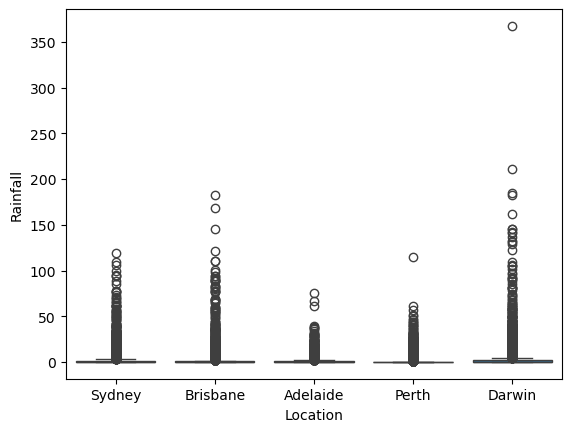

In [4]:
sns.boxplot(x="Location", y="Rainfall",data=df_5c)

A diferencia de las otras ciudades en Darwin se observa que el máximo esta muy por encima de los demás outliers. Para medir que tan lejano se encuentra el dato se procede a restar el percentil 99 del máximo en todas las ciudades.
También se imprimen 5 filas (días) antes y después de la fila del dato anómalo, y se analiza que relación guardan las variables entre las distintas fechas para saber si fue un error de medición o un dato real.

In [5]:

# se obtienen maximo de precipitación por ciudad
df5_max=df_5c.groupby(["Location"])\
[['Rainfall']].max().reset_index()
# se obtiene el percentil 99 de cada ciudad
df5_percentiles_99=df_5c.groupby(["Location"])\
[['Rainfall']].quantile(0.99).reset_index()
#se imprime la diferencia entre el máximo y el percentil 99
print("ciudad, máximo, percentil99, maximo - percentil99:")
for i in range(len(cities)):
    print(cities[i],round(df5_max.Rainfall.values[i],2),round(df5_percentiles_99.Rainfall.values[i],2),\
          round((df5_max.Rainfall.values[i]-df5_percentiles_99.Rainfall.values[i]),2)) 

# Se obtiene la fila (con todas las variables donde se encuentra el dato 
darwin_max=darwin_rain_mean=df_5c.loc[df_5c.Location=="Darwin","Rainfall"].max()
darwin_max_row=df_5c.loc[(df_5c.Rainfall == darwin_max) & (df_5c.Location == "Darwin") , :]
#vemos indice, y obtenemos 5 valores arriba y abajo de la fila donde esta el maximo
index=darwin_max_row.index.values[0]
print("índice de la fila del máximo en Darwin:", index)
df_darwin_anomalia_11=df_5c.loc[index-5:index+6]
print(df_darwin_anomalia_11)

ciudad, máximo, percentil99, maximo - percentil99:
Perth 75.2 21.64 53.56
Sydney 182.6 61.96 120.64
Darwin 367.6 74.9 292.7
Adelaide 114.4 27.22 87.18
Brisbane 119.4 52.3 67.1
índice de la fila del máximo en Darwin: 140071
              Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
140066  2011-02-11   Darwin     24.4     30.5      49.4          7.4   
140067  2011-02-12   Darwin     23.2     31.4      36.8          4.8   
140068  2011-02-13   Darwin     23.9     31.5       8.6          4.4   
140069  2011-02-14   Darwin     23.0     27.6      25.4          7.4   
140070  2011-02-15   Darwin     22.9     24.8     132.6          9.4   
140071  2011-02-16   Darwin     22.1     25.6     367.6          NaN   
140072  2011-02-17   Darwin     23.4     28.6     184.6          NaN   
140073  2011-02-18   Darwin     23.8     26.9      40.0          4.0   
140074  2011-02-19   Darwin     23.3     28.5      88.6          9.4   
140075  2011-02-20   Darwin     24.5     30.4       5.2  

Podemos ver que el máximo en Darwin esta muy por encima del percentil 99 en comparacion a las otras ciudades. Y notamos información interesante de obtener 5 filas (fechas) antes y despues del máximo valor en Darwin. Se oberva que el día del máximo la variable  de presión presenta un valor bajo respecto a los otros días. Esto es un indicio de un sistema de baja presión, generalmente asociado a ciclones tropicales u otro sistema de mesoescala. También se observa que días previos y posteriores al máximo también hubo precipitación considerable. 

Para saber que estaba sucediendo, se buscó información sobre lluvia en esas fechas en la región de Darwin. Se encontró en Wikipedia (2024) que esos días entró el huracán Carlos a la región, siendo esto consistente con las mediciones. A pesar de encontrar que dicho dato anómalo no es un error de medición, se decidió cambiarlo por NaN, para que no haya un sesgo en los siguientes análisis y procesamiento de datos. No obstante, si este trabajo consistiera en analizar eventos extremos de precipitación, dicha información es imprescindible. 

Referencias 

Wikipedia. (2024). *Cyclone Carlos*. https://en.wikipedia.org/wiki/Cyclone_Carlos

Reemplazamos dato máximo de lluvia en Darwin por NaN y volvemos a hacer el boxplot.

<Axes: xlabel='Location', ylabel='Rainfall'>

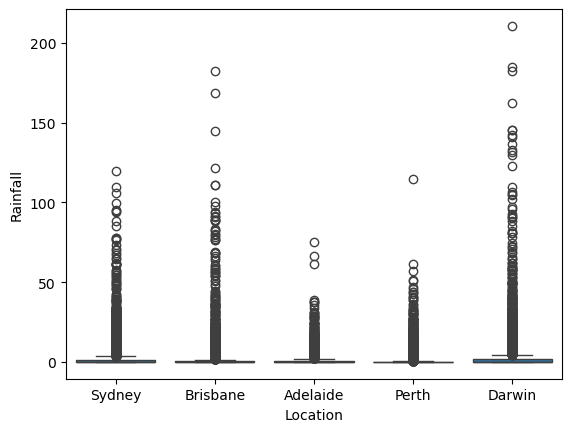

In [6]:
df_5c.loc[(df_5c.Rainfall == darwin_max) & (df_5c.Location == "Darwin") , "Rainfall"]=np.nan
sns.boxplot(x="Location", y="Rainfall",data=df_5c)

#### Conclusión de la limpieza de datos
Es importante analizar la información antes de hacerle un cambio o eliminarla. En este caso se buscó la causa del dato anómalo y se reemplazó en el entendido que esta información no es vital para el tipo de análisis que se esta haciendo.

## Reducción de dimensionalidad

En esta sección se hacen aplican diversas técnicas de reducción de dimensionalidad (RD) vistas en clase. Esto puede permitir obervar las distintas climatologías por ciudad, ya observadas en la práctica 1.

Primero se vuelve a graficar el pairplot, usando también la precipitación diaria promedio, con las 5 ciudades elegidas y las mismas variables utilizadas en el análisis de la práctica 1.

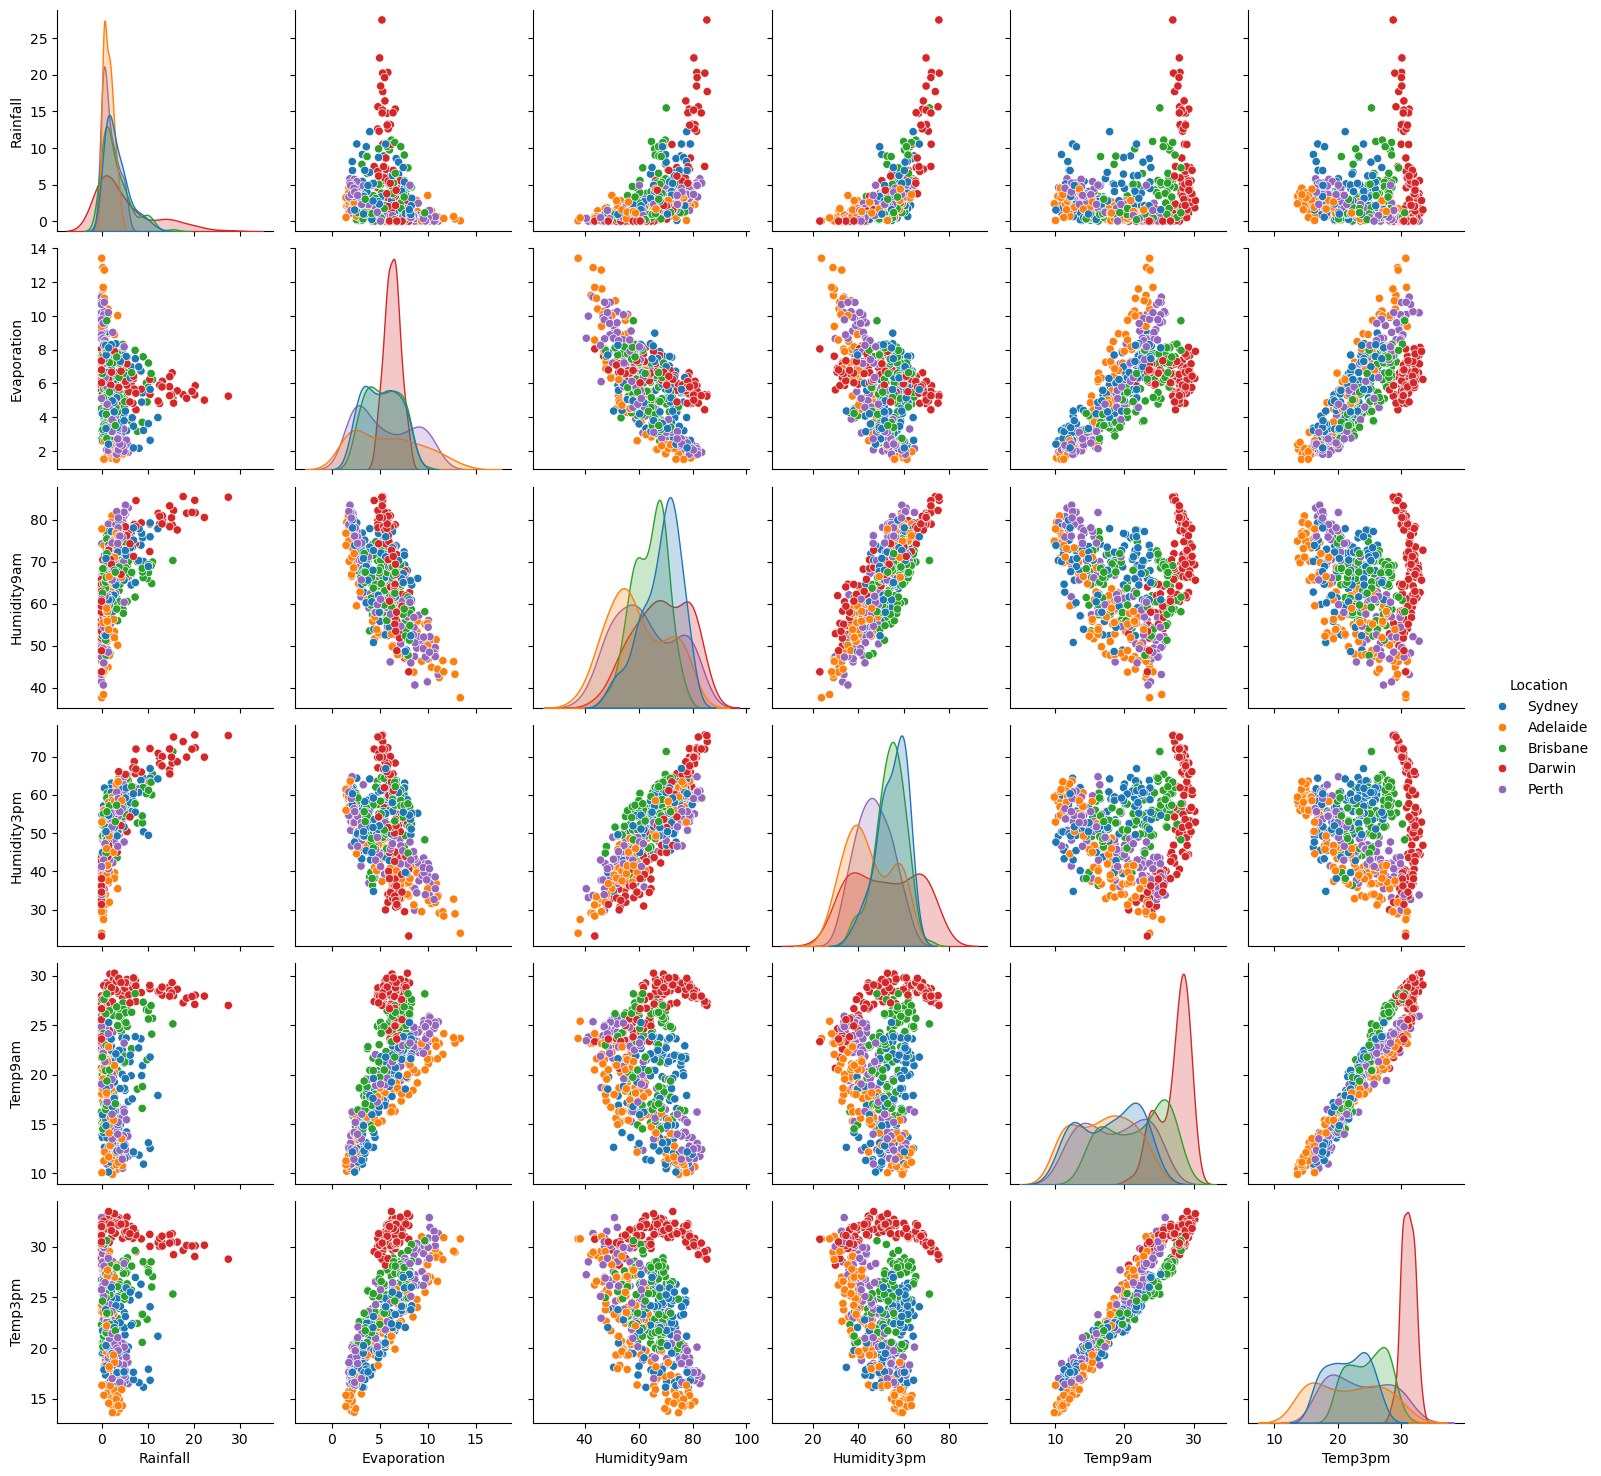

In [7]:
df5_vars=df_5c.loc[:,['Date','Location','Rainfall','Evaporation','Humidity9am','Humidity3pm','Temp9am','Temp3pm']]
df5_vars_mean=df5_vars.groupby([pd.PeriodIndex(df5_vars['Date'], freq="M"),"Location"])\
[['Rainfall','Evaporation','Humidity9am','Humidity3pm','Temp9am','Temp3pm']].mean().reset_index()
sns.pairplot(df5_vars_mean, hue='Location')

Podemos observar que solo Darwin se separa de las demás ciudades en casi todas las variables. Lo contrario sucede en los demás casos, donde los datos entre ciudades se sobreponen.

#### Preparación de datos para métodos de RD
Se obtienen las matrices X y y necesarias para aplicar las técnicas de reducción de dimensionalidad

In [8]:
#quitamos valores con nan para poder realizar las pruebas de RD
df5_vars_mean_nonan=df5_vars_mean.dropna()
print(df5_vars_mean.shape)
print(df5_vars_mean_nonan.shape)
#quitamos la columna de fechas
df5_vars_reduced=df5_vars_mean_nonan.loc[:, df5_vars_mean_nonan.columns != 'Date']
# Obtenemos x para la reducción de dimensionalidad
X = df5_vars_reduced.loc[:, df5_vars_reduced.columns != 'Location'].values
# Obtenemos y para la reducción de dimensionalidad
y0=[]
for i in df5_vars_reduced.Location.values:
    if i == "Sydney":
        y0.append(1)
    elif i == "Adelaide":
        y0.append(2)
    elif i == "Brisbane":
        y0.append(3)
    elif i == "Darwin":
        y0.append(4)
    else:
        y0.append(5)
y = y0
print(y)

(530, 8)
(506, 8)
[1, 1, 1, 1, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 

### Técnicas de reducción de dimensionalidad: PCA, LDA, t-SNE, UMAP.
Consisten de las técnicas vistas en clase.

#### PCA
Técnica de RD lineal mas popular. Reduce el número de dimensiones en componentes principales que retienen la mayor información original posible (IBM, 2023).

Referencia: IBM. (2023). *What is principal component analysis (PCA)?*. https://www.ibm.com/topics/principal-component-analysis
 


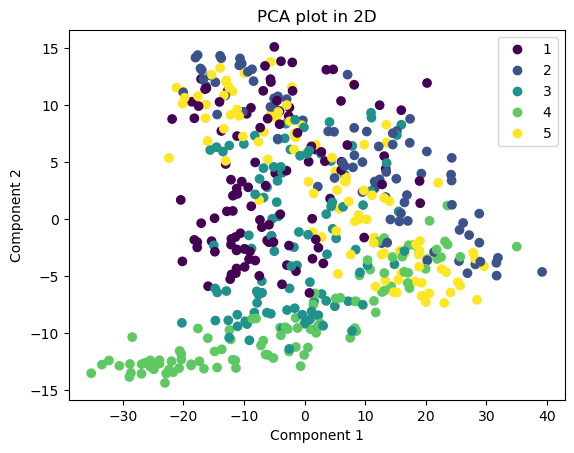

In [9]:
X_PCA = PCA(n_components=2).fit_transform(X)

scatter = plt.scatter(X_PCA[:,0], X_PCA[:,1], c=y)
plt.title('PCA plot in 2D')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(*scatter.legend_elements())
plt.show()

Vemos que la clase 4 (Darwin) se separa un poco de las demás, pero no es muy clara la separación.

#### LDA

Técnica lineal que separa multiples clases con multiples variables a través de RD (IBM, 2023).

Referencia: IBM. (2023). *What is LDA?*. https://www.ibm.com/topics/linear-discriminant-analysis

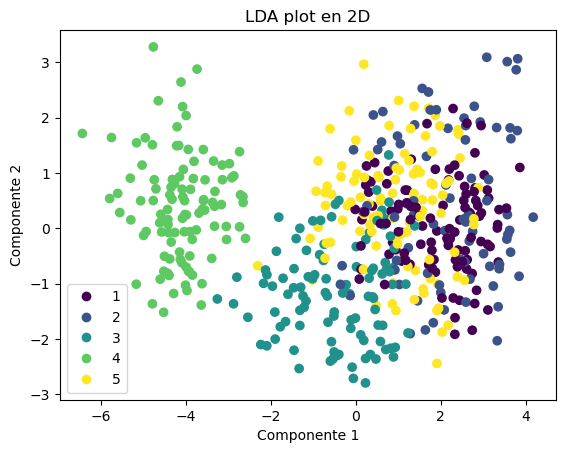

In [10]:
X_LDA = LDA(n_components=2).fit_transform(X,y)

scatter = plt.scatter(X_LDA[:,0], X_LDA[:,1], c=y)
plt.title('LDA plot en 2D')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.legend(*scatter.legend_elements())
plt.show()

Aquí es mucho más claro el cluster de Darwin, y relativamente claro el de Brisbane. En los demás clusters no hay una distinción clara.

#### T-SNE
Método no lineal para visualizar datos de alta dimensionalidad, que asigna a cada punto de datos una ubicación en un mapa de 2 o 3 dimensiones (Wikipedia, 2024).

Referencia:
Wikipedia. (2024). *t-distributed stochastic neighbor embedding*. https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding

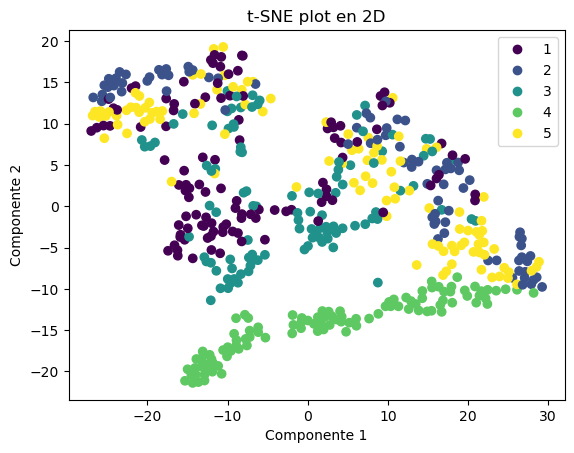

In [11]:
X_TSNE = TSNE(n_components=2).fit_transform(X)

scatter = plt.scatter(X_TSNE[:,0], X_TSNE[:,1], c=y)
plt.title('t-SNE plot en 2D')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.legend(*scatter.legend_elements())
plt.show()

El cluster de Darwin parece separada, pero esta muy segregado. X-TSNE no es la técnica más adecuada para el dataset.

#### UMAP
Método similar a T-SNE, pero con implementación matématica distinta (Luna, 2023).

Referencia: Luna, F. (2023). *UMAP: An alternative dimensionality reduction technique*. https://medium.com/mcd-unison/umap-an-alternative-dimensionality-reduction-technique-7a5e77e80982

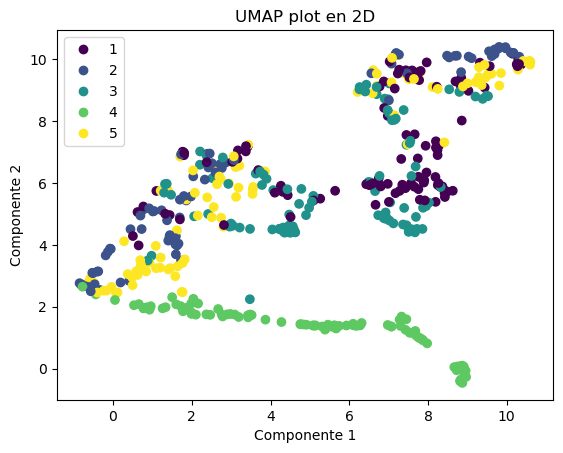

In [12]:
X_UMAP = UMAP(n_components=2).fit_transform(X)

scatter = plt.scatter(X_UMAP[:,0], X_UMAP[:,1], c=y)
plt.title('UMAP plot en 2D')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.legend(*scatter.legend_elements())
plt.show()

EL patrón de clasificación es similar al obtenido con T-SNE.

### Conclusiones de reducción de dimensionalidad
La mejor clasificación fue obtenida por el método LDA, donde se pudo osbervar los puntos de Darwin y de Brisbane (relativamente) separados de las demás ciudades, lo cual indica una climatología totalmente distinta para tales ciudades. Aunado a lo anterior, en Dutta-Barua (2023) es mencionado que LDA es una técnica más apropiada para clasificación en lugar de PCA. 
Por otra parte, se observó que T-SNE y UMAP, arrojaron resultados parecidos, consistente con la similitud entre técnicas. 

Referencia: Dutta-Barua, I. (2023). *Dimensionality Reduction Techniques — PCA, LCA and SVD*. https://medium.com/nerd-for-tech/dimensionality-reduction-techniques-pca-lca-and-svd-f2a56b097f7c#:~:text=Unsupervised%20vs%20Supervised%20Learning%3A%20PCA,SVD%20focus%20on%20overall%20variance.

## Selección de características

A diferencia de la práctica pasada,  en lugar de hacer una clasificación por ciudad el enfoque de esta sección es sobre la variable de "RainTomorrow",. Se implementan diversas técnicas de selección de características con el fin de ver que variables se relacionan más con nuestra variable de interés. De alguna manera esto nos dice que variables sirven, por ejemplo, para pronosticar si va a llover el día de mañana.

Primero hacemos un subset de nuestro Dataframe, con las variables que nos interesan. En este caso se omiten variables categóricas (con excepción de "RainToday") o qué no están muy relacionadas con la precipitación. También cambiamos "yes" y "no", por 1 y 0s. 

In [13]:
df1=df_5c.loc[:,['Rainfall','Evaporation','Humidity9am','Humidity3pm','Temp9am','Temp3pm',\
                 'MinTemp', 'MaxTemp','Cloud9am','Cloud3pm','RainToday','RainTomorrow']]
replace_dict = {'Yes': '1', 'No': '0'}
df1=df1.replace(replace_dict)
print(df1)

        Rainfall  Evaporation  Humidity9am  Humidity3pm  Temp9am  Temp3pm  \
30176       15.6          6.2         92.0         84.0     20.7     20.9   
30177        6.0          3.4         83.0         73.0     22.4     24.8   
30178        6.6          2.4         88.0         86.0     23.5     23.0   
30179       18.8          2.2         83.0         90.0     21.4     20.9   
30180       77.4          NaN         88.0         74.0     22.5     25.5   
...          ...          ...          ...          ...      ...      ...   
142299       0.0          7.6         56.0         28.0     24.8     32.0   
142300       0.0          5.6         46.0         23.0     24.8     32.1   
142301       0.0          6.2         62.0         58.0     24.8     29.2   
142302       0.0          5.6         73.0         32.0     25.4     31.0   
142303       0.0          5.0         68.0         45.0     24.6     29.0   

        MinTemp  MaxTemp  Cloud9am  Cloud3pm RainToday RainTomorrow  
30176

#### Pairplot
Hacemos pairplot para observar de antemano las posibles relaciones con la variable "RainTomorrow"

In [ ]:
sns.pairplot(df1, hue='RainTomorrow')

Visualmente se puede notar la separación de grupos conforme a la variable "RainTomorrow". En orden jerarquico, intuitivamente estas variabels son: Humidity3pm, Cloud3pm, Humidity9am, Cloud9am y Rainfall.

Se prepara Dataframe y vectores X y y para hacer las diversas técnicas de selección de características

In [ ]:
# se quitan filas con NaN
df2=df1.dropna()
#Se definen X y y
X = df2.iloc[:, :-1]
print(X)
y = df2.iloc[:, -1]
print(y)

### Técnicas de selección de características

#### Mutual information
Esta prueba nos permite ver la dependencia entre 2 variables.

In [ ]:
from sklearn.feature_selection import mutual_info_classif

# tiempo inicial
start_time_forward = time.time()

### Aplicando método de selección de variables
X_new = mutual_info_classif(X, y)

# tiempo final
end_time_forward = time.time()
time_forward = end_time_forward - start_time_forward

# se grafica selección de variables
feat_imp = pd.Series(X_new, X.columns)
feat_imp.plot(kind='barh')
plt.show()

# tiempo de ejecución del método
print(f"Tiempo de ejecución: {time_forward:.2f} segundos")

Podemos ver que la variable más relacionada a "RainTomorrow" es "Humidity3pm", tal como se intuyo a partir del pairplot. Las variables que le siguen son Cloud3pm, Cloud9am, Rainfall y Humidity9am. Es curioso como la variable RainToday no está entre las primeras 5, y que Rainfall no es la más relacionada. Es decir, el hecho que haya llovido un día antes no es el criterio más fuerte para predecir si va a llover mañana, sino la humedad relativa a las 3pm, por lo visto hasta ahora.

#### Univariate feature selection
Esta prueba selecciona las mejores variables basada en pruebas estadísticas univariadas.

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# tiempo inicial
start_time_forward = time.time()

### Aplicando método de selección de variables
select_kbest = SelectKBest(score_func=f_classif, k=5)  # change k
select_kbest.fit_transform(X, y)

# tiempo final
end_time_forward = time.time()
time_forward = end_time_forward - start_time_forward

# se muestran variables seleccionadas
selected_features = select_kbest.get_support()
print('Variables obtenidas:', list(X.columns[selected_features]))

# tiempo de ejecución del método
print(f"Tiempo de ejecución: {time_forward:.2f} segundos")

Obvservamos las mismas variables obtenidas en pruebas anteriores.

#### Correlación
Esta prueba permite saber la relación lineal entre dos variables.

Obtenemeos matriz de correlación y la graficamos

In [ ]:
df3= df2.iloc[:, 2:]
cor = df3.corr()
sns.heatmap(cor, annot = True)

Se imprimen las variables con mayor correlación a la variable "RainTomorrow"

In [ ]:
# tiempo inicial
start_time_forward = time.time()

### Aplicando método de selección de variables
correlation_matrix = cor
corr_with_target = correlation_matrix["RainTomorrow"].drop("RainTomorrow")

# tiempo final
end_time_forward = time.time()
time_forward = end_time_forward - start_time_forward

# Ordena y muestra variables con el valor de correlación absoluta
sorted_corr = corr_with_target.abs().sort_values(ascending=False)
print(f"Absolute Correlations with the Objective (RainTomorrow):\n{sorted_corr}")

# Se define umbral para la correción (mantiene variables con |correlación| > 0.2)
threshold = 0.2
selected_features_corr = sorted_corr[sorted_corr > threshold].index.tolist()
print(f"Variables obtenidas: {selected_features_corr}")

# tiempo de ejecución del método
print(f"Tiempo de ejecución: {time_forward:.2f} segundos")

Nuevamente observamos en los 3 primeros lugares a las variables de Humidity3pm, Cloud3pm y Cloud9am, como en la prueba Mutual Information.

#### Forward Selection
Es un método iterativo que compara las variables de elección con la variable objetivo. Despues, elige otras variable que arroja el mejor resultado en combinación con la variable anterior. Esto se realiza hasta completar el criterio preestablecido.

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

# tiempo inicial
start_time_forward = time.time()

### Aplicando método de selección de variables
ffs = SequentialFeatureSelector(lr, n_features_to_select='auto', direction='forward')
ffs.fit(X, y)

# tiempo final
end_time_forward = time.time()
time_forward = end_time_forward - start_time_forward

# se muestran variables seleccionadas
selected_features = ffs.get_support()
print('Variables obtenidas:', list(X.columns[selected_features]))

# tiempo de ejecución del método
print(f"Tiempo de ejecución: {time_forward:.2f} segundos")

Podemos notar que  la variable Cloud9am desaparece de la selección y en lugar de ella esta Raintoday. Esta prueba contradice un poco a las anteriores. No obstante, mantiene el mismo núcleo de variables.

### Conclusiones de la selección de características
Con las diversas técnicas de selección de caracerísticas se encontraron las variables que más se relacionan a "RainTomorrow". Entre ellas están: Humidity3pm, Cloud3pm, Cloud9am, Humidity9am, Rainfall, y RainToday. En la mayoría de pruebas las variables dominantes fueron Humidity 3pm, Cloud 3pm y Cloud9am, siendo Humidity la más importante con una correlación de 0.53. Con los resultados obtenidos puede decirse que es posible "pronósticar" la precipitación con base en unas cuantas variables. Esto de gran interés en el área de los modelos númericos y el pronóstico del tiempo, donde el costo computacional de los modelos es muy alto. Por lo anterior, es interesante indagar en las técnicas que nos permiten adentrarnos en la Ciencias de Datos e Inteligencia Artifical, con el fin de descubrir métodos que permiten eficientar procesos y ahorrar recursos.

### Conclusiones de la práctica
Se implementaron tres tipos de procesamiento de datos: limpieza de datos, reducción de dimensionalidad y selección de características. En cada procesamiento se hizo análisis y generación de nueva información. En la limpieza de datos se analizó el origen de la anomlía y una vez analizado el caso se reemplazó el dato. En la reducción de dimensionalidad, se ocuparon diversos métodos, encontrando que LDA era el más adecuada para diferenciar la climatología entre ciudades. Por último, en la selección de caracteristicas fue posible encontrar las principales variables asociadas a "RainTomorrow", estableciendo así un núcleo de variables que pueden ayudar a predecir el tiempo atmosérico. 
Es importante estudiar, aplicar y analizar las diversas herramientas que nos ofrece la Ciencia de Datos, con el fin de generar conocimiento útil de manera eficiente. En este caso, de manera rápida y consistente fue posible clasificar la climatología entre algunas ciudades y encontrar variables que pueden ayudar al pronóstico del tiempo.
